In [1]:
import os
import yaml
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
import datetime
%matplotlib inline

In [2]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint
from desisurvey.progress import Progress
import desisurvey.config

# Environment Variables 

Set some environment variables and create output directories



In [17]:
alldirs = {}

os.environ['DESISURVEY_OUTPUT'] = '/global/projecta/projectdirs/desi/datachallenge/surveysim2017/baseline_1m'

basedir = os.path.join(os.environ['SCRATCH'],'elgsplit')

surveydir = os.path.join(basedir,'survey')
fiberassigndir =  os.path.join(basedir, 'fiberassign')
alldirs['surveydir'] = surveydir
alldirs['fiberassigndir'] = fiberassigndir

brighttargetdir = os.path.join(basedir,'targets/bright')
darktargetdir = os.path.join(basedir,'targets/dark')
alldirs['brighttargetdir'] = brighttargetdir
alldirs['darktargetdir'] = darktargetdir

zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
alldirs['zcatbrightdir'] = zcatbrightdir
alldirs['zcatdarkdir'] = zcatdarkdir

alltargetdir = os.path.join(basedir,'targets/bright')
zcatalldir = os.path.join(basedir,'zcat/all')
alldirs['alltargetdir'] = alltargetdir
alldirs['zcatalldir'] = zcatalldir

In [18]:
for k in alldirs.keys():
    print('Creating {}: {}'.format(k, alldirs[k]))
    os.makedirs(alldirs[k], exist_ok=True)

Creating zcatdarkdir: /global/cscratch1/sd/forero/elgsplit/zcat/dark
Creating darktargetdir: /global/cscratch1/sd/forero/elgsplit/targets/dark
Creating fiberassigndir: /global/cscratch1/sd/forero/elgsplit/fiberassign
Creating zcatbrightdir: /global/cscratch1/sd/forero/elgsplit/zcat/bright
Creating zcatalldir: /global/cscratch1/sd/forero/elgsplit/zcat/all
Creating surveydir: /global/cscratch1/sd/forero/elgsplit/survey
Creating alltargetdir: /global/cscratch1/sd/forero/elgsplit/targets/bright
Creating brighttargetdir: /global/cscratch1/sd/forero/elgsplit/targets/bright


# Extract exposures files from `progress` data

`progress.fits` is the file that summarizes the survey simulation performed with `desisurvey`

We read that file and write to disk a file with all the `exposures`
made during the survey and two more files with the exposures for dark and bright
surveys. **NOTE**: We include grey exposures into `all_exposures_dark` file.

Bright twilight tiles should be excluded because we don't have a right sky model, but we are including them here anyway.

In [5]:
#generate the list of exposures from the 'progress.fits' file

progress_filename = os.path.join(os.environ['DESISURVEY_OUTPUT'],'progress.fits')
exposures_filename = os.path.join(alldirs['surveydir'],'exposures.fits')

Progress(restore=progress_filename).get_exposures().write(exposures_filename, overwrite=True)    
explist = Table.read(exposures_filename)

INFO:progress.py:145:__init__: Loaded progress from /global/projecta/projectdirs/desi/datachallenge/surveysim2017/baseline_1m/progress.fits.


In [6]:
# separate the exposures for dark and bright programs
isbright = explist['PASS'] > 4 
isdark = ~isbright
    
exposurefile_bright = os.path.join(alldirs['surveydir'],'all_exposures_bright.fits')
Table(explist[isbright]).write(exposurefile_bright, overwrite=True)

exposurefile_dark = os.path.join(alldirs['surveydir'],'all_exposures_dark.fits')
Table(explist[~isbright]).write(exposurefile_dark, overwrite=True)

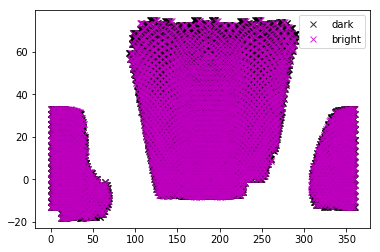

In [7]:
# Make a simple plot
plt.plot(explist['RA'][isdark], explist['DEC'][isdark], 'kx', alpha=0.8, label='dark')
plt.plot(explist['RA'][isbright], explist['DEC'][isbright], 'mx', alpha=0.8, label='bright')
plt.legend(loc='upper right')

# Select a subset of tiles

Select a small subset of tiles separately for `dark` and `bright` survey.
`quicksurvey`+`fiberassign` will run on those tiles.

In [21]:
def select_subset_exposures_tiles(program="dark", plot=True):
    tiles = desimodel.io.load_tiles()
    explist = Table.read(os.path.join(alldirs['surveydir'],'all_exposures_{}.fits'.format(program)))
#    subset = (explist['RA']>130)&(explist['RA']<180)  & (explist['DEC']<20)
    subset = (explist['RA']>130)&(explist['RA']<140)  & (explist['DEC']<0)

    exposurefile = os.path.join(alldirs['surveydir'],'subset_exposures_{}.fits'.format(program))
    Table(explist[subset]).write(exposurefile, overwrite=True)

    tilefile = os.path.join(alldirs['surveydir'],'subset_tiles_{}.fits'.format(program))
    xtiles = tiles[np.in1d(tiles['TILEID'], explist['TILEID'][subset])]
    Table(xtiles).write(tilefile, overwrite=True)
    
    if plot:
        plt.scatter(xtiles['RA'], xtiles['DEC'], label=program, s=100, alpha=0.5)
        plt.legend()
        plt.xlabel("RA [deg]")
        plt.ylabel("DEC [deg]")
        plt.title("Tiles to be simulated")

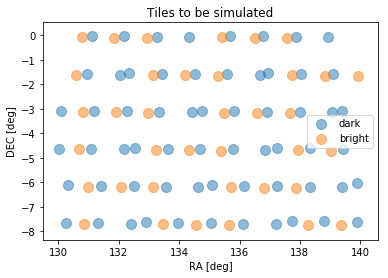

In [22]:
select_subset_exposures_tiles(program="dark")
select_subset_exposures_tiles(program="bright")

# Run serial select_mock_targets --no-spectra

In [20]:
select_mock_targets_cmd  = "select_mock_targets --no-spectra -c {yamlconfigfile} --nside {healpixnside} --output_dir {outputdir} --seed {seed} --tiles {tilefile}"

cmd = select_mock_targets_cmd.format(yamlconfigfile=os.path.join(alldirs['darktargetdir'],'select-mock-targets-dark.yaml'),
                                    healpixnside=8,
                                    outputdir=darktargetdir,
                                    seed=10,
                                    tilefile=os.path.join(alldirs['surveydir'],'subset_tiles_dark.fits'))
print(cmd)

select_mock_targets --no-spectra -c /global/cscratch1/sd/forero/elgsplit/targets/dark/select-mock-targets-dark.yaml --nside 8 --output_dir /global/cscratch1/sd/forero/elgsplit/targets/dark --seed 10 --tiles /global/cscratch1/sd/forero/elgsplit/survey/subset_tiles_dark.fits


In [11]:
! $cmd

INFO:select_mock_targets:44:<module>: Starting select_mock_targets at Wed Nov 15 21:28:06 2017
INFO:select_mock_targets:62:<module>: 51 tiles
INFO:select_mock_targets:73:<module>: 18/18 pixels remaining to do
INFO:select_mock_targets:100:<module>: Reading configuration file /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/select-mock-targets-dark.yaml
INFO:select_mock_targets:104:<module>: Calling targets_truth at Wed Nov 15 21:28:07 2017
INFO:build.py:1145:initialize: Writing to output directory /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark
INFO:build.py:1155:initialize: Grouping into 18 healpixel(s) (nside = 16, 13.429 deg2/pixel) spanning 241.717 deg2.
INFO:build.py:1159:initialize: Initializing the MockMagnitudes and SelectTargets Classes.

INFO:build.py:1674:targets_truth_no_spectra: Reading  source : ELG
INFO:build.py:1214:read_catalog: Source: ELG, target: ELG, format: gaussianfield
INFO:build.py:1215:read_catalog: Reading /projec

In [12]:
select_mock_targets_cmd  = "select_mock_targets --no-spectra -c {yamlconfigfile} --nside {healpixnside} --output_dir {outputdir} --seed {seed} --tiles {tilefile}"

cmd = select_mock_targets_cmd.format(yamlconfigfile=os.path.join(alldirs['brighttargetdir'],'select-mock-targets-bright.yaml'),
                                    healpixnside=16,
                                    outputdir=brighttargetdir,
                                    seed=10,
                                    tilefile=os.path.join(alldirs['surveydir'],'subset_tiles_bright.fits'))
print(cmd)

select_mock_targets --no-spectra -c /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/select-mock-targets-bright.yaml --nside 16 --output_dir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright --seed 10 --tiles /global/cscratch1/sd/forero/quicksurvey_example/survey/subset_tiles_bright.fits


In [13]:
! $cmd

INFO:select_mock_targets:44:<module>: Starting select_mock_targets at Wed Nov 15 21:34:44 2017
INFO:select_mock_targets:62:<module>: 30 tiles
INFO:select_mock_targets:73:<module>: 18/18 pixels remaining to do
INFO:select_mock_targets:100:<module>: Reading configuration file /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/select-mock-targets-bright.yaml
INFO:select_mock_targets:104:<module>: Calling targets_truth at Wed Nov 15 21:34:44 2017
INFO:build.py:1145:initialize: Writing to output directory /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
INFO:build.py:1155:initialize: Grouping into 18 healpixel(s) (nside = 16, 13.429 deg2/pixel) spanning 241.717 deg2.
INFO:build.py:1159:initialize: Initializing the MockMagnitudes and SelectTargets Classes.

INFO:build.py:1674:targets_truth_no_spectra: Reading  source : BGS
INFO:build.py:1214:read_catalog: Source: BGS, target: BGS, format: durham_mxxl_hdf5
INFO:build.py:1215:read_catalog: Readin

In [14]:
cmd = "join_mock_targets --mockdir "+darktargetdir
print(cmd)
! $cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/sky.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/standards-dark.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/standards-bright.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/targets.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/truth.fits
INFO:build.py:1073:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark/mtl.fits
DEBUG:targets.py:335:calc_priority: before targets.calc_priority slow copy
DEBUG:targets.p

In [15]:
cmd = "join_mock_targets --mockdir "+brighttargetdir
print(cmd)
! $cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/sky.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/standards-dark.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/standards-bright.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/targets.fits
INFO:build.py:996:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/truth.fits
INFO:build.py:1073:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright/mtl.fits
DEBUG:targets.py:335:calc_priority: before targets.calc_priority slow copy
D

In [14]:
# some sanity checks on the results

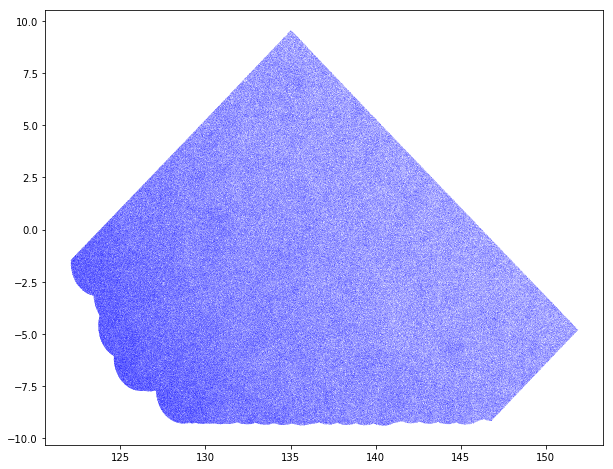

In [24]:
targets = fitsio.read(os.path.join(alldirs['darktargetdir'],'targets.fits'))
truth   = fitsio.read(os.path.join(alldirs['darktargetdir'],'truth.fits'))
mtl     = fitsio.read(os.path.join(alldirs['darktargetdir'],'mtl.fits'))
std     = fitsio.read(os.path.join(alldirs['darktargetdir'],'standards-dark.fits'))
sky     = fitsio.read(os.path.join(alldirs['darktargetdir'],'sky.fits'))

assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], color='blue', alpha=0.1, s=0.01)
#plt.plot(std['RA'], std['DEC'], 'm.')

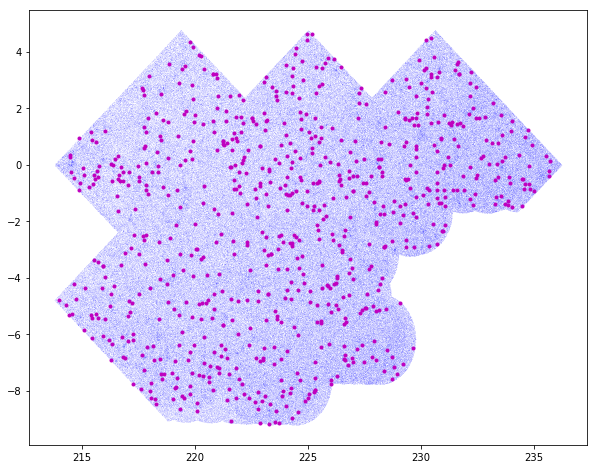

In [18]:
targets = fitsio.read(os.path.join(alldirs['brighttargetdir'],'targets.fits'))
truth   = fitsio.read(os.path.join(alldirs['brighttargetdir'],'truth.fits'))
mtl     = fitsio.read(os.path.join(alldirs['brighttargetdir'],'mtl.fits'))
std     = fitsio.read(os.path.join(alldirs['brighttargetdir'],'standards-dark.fits'))
sky     = fitsio.read(os.path.join(alldirs['brighttargetdir'],'sky.fits'))

assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], color='blue', alpha=0.1, s=0.01)
plt.plot(std['RA'], std['DEC'], 'm.')

# Run quicksurvey


## Fiberassign dates

From the `surveysim` data we have to find the dates when `fiberassign` is expected to be run

In [25]:
def compute_fiberassign_dates(exposurefile, outputfile):
    """
    Computes the dates to read fiberassign from the data in a 'exposures' files.
    
    Args:
        exposurefile (str):
        Name of the file with 'exposures' data
    Return:
        fiberassign_dates_run (list):
        List of string dates where fiberassign should be run.
    """
    desisurvey_path = os.getenv('DESISURVEY_OUTPUT')
    exposures = Table.read(exposurefile)
    expdates = []
    for n in exposures['NIGHT']:
        a = datetime.datetime.strptime(n, "%Y%m%d")
        expdates.append(a.date())
    expdates = np.array(expdates)
    # print("expdates {}".format(expdates))
    
    # compute the dates for fiberassign
    progress = Table.read(os.path.join(desisurvey_path,'progress.fits'))
    fiberassign_dates = np.sort(list(set(progress['available'])))
    fiberassign_dates = fiberassign_dates[fiberassign_dates>0]
    
    #load the first date of the survey
    config = desisurvey.config.Configuration()
    first_day = config.first_day()
    last_day = config.last_day()
    
    #compute the dates to run fiberassign to be sure that there is at least one exposure there
    fiberassign_dates_run = []
    one_day = datetime.timedelta(days=1)
    initial_day = first_day 
    #print(fiberassign_dates)
    for d in fiberassign_dates:
        final_day = first_day + d * one_day
        ii = (expdates > initial_day) & (expdates<=final_day)
        n_in = np.count_nonzero(ii)
        if n_in>0:
            #print(initial_day, final_day, n_in)
            fiberassign_dates_run.append(initial_day.strftime("%Y-%m-%d"))
            initial_day = final_day
                
    f = open(outputfile, 'w')
    for d in fiberassign_dates_run:
        f.write(d+"\n")
    f.close()          

In [26]:
program = "dark"
exposurefile = os.path.join(alldirs['surveydir'],'subset_exposures_{}.fits'.format(program))
fiberassignfile = os.path.join(alldirs['fiberassigndir'], 'subset_{}_fiberassign_dates.txt'.format(program))
compute_fiberassign_dates(exposurefile, fiberassignfile)

program = "bright"
exposurefile = os.path.join(alldirs['surveydir'],'subset_exposures_{}.fits'.format(program))
fiberassignfile = os.path.join(alldirs['fiberassigndir'], 'subset_{}_fiberassign_dates.txt'.format(program))
compute_fiberassign_dates(exposurefile, fiberassignfile)

In [22]:
quicksurvey_cmd = "quicksurvey -T {targetdir} -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(targetdir=alldirs['darktargetdir'],
                            exposures=alldirs['surveydir']+'/subset_exposures_dark.fits', 
                            outputdir=alldirs['zcatdarkdir'], 
                            fiberassign_template=alldirs['fiberassigndir']+'/template_fiberassign_dark.txt', 
                            fiberassign_dates=alldirs['fiberassigndir']+'/subset_dark_fiberassign_dates.txt')
print(cmd)
! $cmd

quicksurvey -T /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark -E /global/cscratch1/sd/forero/quicksurvey_example/survey/subset_exposures_dark.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark -f $(which fiberassign) -t /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/template_fiberassign_dark.txt -D /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/subset_dark_fiberassign_dates.txt
['20191201', '20200605', '20210327', '20210426', '20210525', '20210623', '20220415', '9999-99-99']
tiles in epoch 0 [20191201 to 20200605]: 8
tiles in epoch 1 [20200605 to 20210327]: 1
tiles in epoch 2 [20210327 to 20210426]: 1
tiles in epoch 3 [20210426 to 20210525]: 2
tiles in epoch 4 [20210525 to 20210623]: 7
tiles in epoch 5 [20210623 to 20220415]: 9
tiles in epoch 6 [20220415 to 9999-99-99]: 24
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'FLUX_G', 

In [23]:
quicksurvey_cmd = "quicksurvey -T {targetdir} -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(targetdir=alldirs['brighttargetdir'],
                            exposures=alldirs['surveydir']+'/subset_exposures_bright.fits', 
                            outputdir=alldirs['zcatbrightdir'], 
                            fiberassign_template=alldirs['fiberassigndir']+'/template_fiberassign_bright.txt', 
                            fiberassign_dates=alldirs['fiberassigndir']+'/subset_bright_fiberassign_dates.txt')
print(cmd)

! $cmd

quicksurvey -T /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright -E /global/cscratch1/sd/forero/quicksurvey_example/survey/subset_exposures_bright.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright -f $(which fiberassign) -t /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/template_fiberassign_bright.txt -D /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/subset_bright_fiberassign_dates.txt
['20191201', '20200208', '20200308', '20200506', '20210127', '20210226', '20210623', '9999-99-99']
tiles in epoch 0 [20191201 to 20200208]: 1
tiles in epoch 1 [20200208 to 20200308]: 1
tiles in epoch 2 [20200308 to 20200506]: 4
tiles in epoch 3 [20200506 to 20210127]: 3
tiles in epoch 4 [20210127 to 20210226]: 1
tiles in epoch 5 [20210226 to 20210623]: 2
tiles in epoch 6 [20210623 to 9999-99-99]: 18
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 

# Read the final redshift catalog

Read the final redshift catalog.

Blue: input catalog.
Red: objects with a redshift.

229289


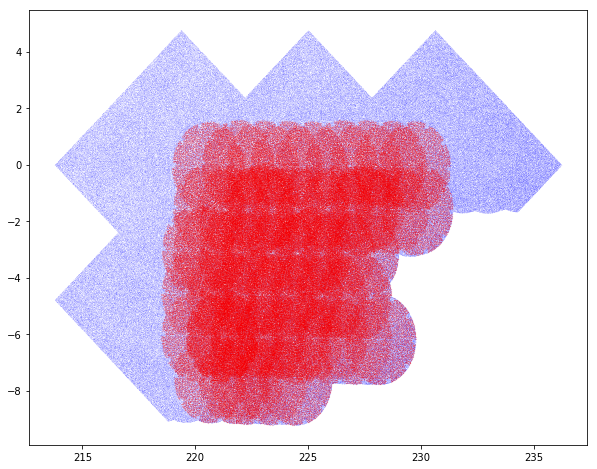

In [24]:
zcatfilename = os.path.join(alldirs['zcatdarkdir'],'6/zcat.fits')
zcat     = fitsio.read(zcatfilename)
mtl     = fitsio.read(os.path.join(alldirs['darktargetdir'],'mtl.fits'))
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.01)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=0.05)
print(np.count_nonzero(zcat_in_mtl))

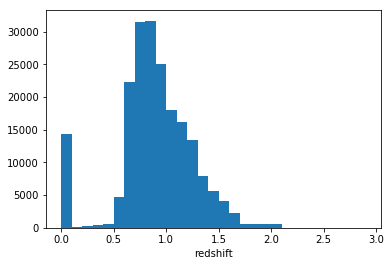

In [25]:
a = plt.hist(zcat['Z'], bins=np.arange(0.0,3.0,0.1))
plt.xlabel('redshift')

148755


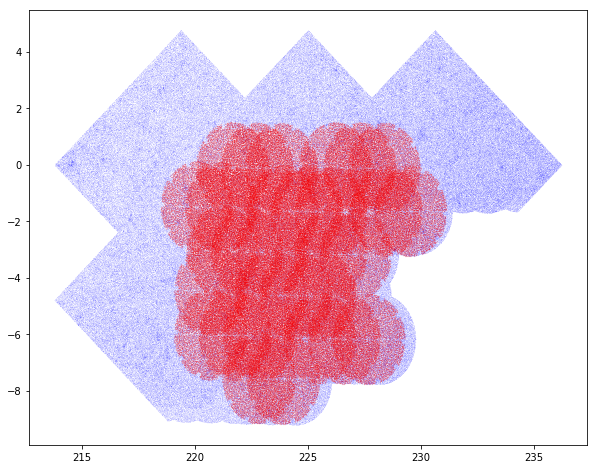

In [26]:
zcatfilename = os.path.join(alldirs['zcatbrightdir'],'6/zcat.fits')
zcat     = fitsio.read(zcatfilename)
mtl     = fitsio.read(os.path.join(alldirs['brighttargetdir'],'mtl.fits'))
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.01)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=0.05)
print(np.count_nonzero(zcat_in_mtl))

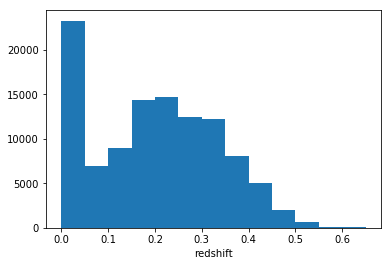

In [27]:
a = plt.hist(zcat['Z'], bins=np.arange(0.0,0.7,0.05))
plt.xlabel('redshift')